## Import Libs

In [1]:
# %load_ext autoreload
# %autoreload 2

import os,sys
sys.path.insert(0, os.path.abspath('../../modules/deepspeech.pytorch') )

import torch
import torch.nn as nn
import hydra
import deepspeech_pytorch


from dataclasses import dataclass, field
from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
# from deepspeech_pytorch.utils import load_model, load_decoder
# from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline

In [2]:
deepspeech_pytorch

<module 'deepspeech_pytorch' from '/scratch/f006pq6/projects/deep-speech-reveal-hessian/modules/deepspeech.pytorch/deepspeech_pytorch/__init__.py'>

In [5]:

from enum import Enum
class SpectrogramWindow(Enum):
    hamming = 'hamming'
    hann = 'hann'
    blackman = 'blackman'
    bartlett = 'bartlett'


@dataclass
class SpectConfig:
    sample_rate: int = 16000  # The sample rate for the data/model features
    window_size: float = .02  # Window size for spectrogram generation (seconds)
    window_stride: float = .01  # Window stride for spectrogram generation (seconds)
    window: SpectrogramWindow = SpectrogramWindow.hamming # Window type for spectrogram generation

@dataclass
class MyConfig:
    precision: int = 32  # Set to 16 to use mixed-precision for inference
    cuda: bool = True
    # model_path: str = ''
    batch_size: int = 1
    num_workers: int = 4

spec_cfg = SpectConfig()
cfg      = MyConfig()

In [7]:
cfg

MyConfig(precision=32, cuda=True, batch_size=1, num_workers=4)

In [8]:
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()



In [10]:
cfg.num_workers

4

In [6]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
# cs = ConfigStore.instance()
# cs.store(name="config", node=EvalConfig)

# cfg = EvalConfig()

# # set bs = 1, device
# cfg.batch_size=1
device = torch.device("cuda")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------
data_loader_iter = iter(test_loader)

# inputs, targets, input_percentages, target_sizes = next() 
# inputs = inputs.to(device)
# targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

# inputs = inputs[:,:,:,-60:-40] # do 100 frames only
# input_percentages[0] = 1.0
# input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
# input_percentages = input_percentages.to(device)

# print('input shape:',inputs.shape)


TypeError: '<' not supported between instances of 'MyConfig' and 'int'

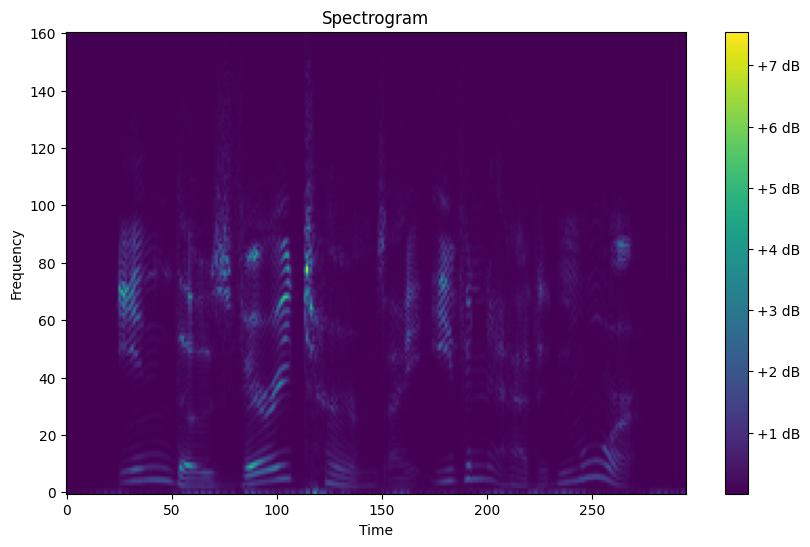

In [18]:
inputs, targets, input_percentages, target_sizes = next(data_loader_iter) 
inputs = inputs.to(device)
targets = targets.to(device)

plot_spectrogram(inputs.detach())

# load inputs, targets, input_percentages, target_sizes from pickle data_loader_values.pkl
# import pickle
# with open( 'data_loader_values.pkl', 'rb') as f:
#     data = pickle.load(f)

In [ ]:
inputs, targets, input_percentages, target_sizes = data

In [ ]:
# # ==============================================================================
# Make the input a bit smaller

inputs = inputs[:,:,:,50:160] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print('input shape:',inputs.shape)
plot_spectrogram(inputs.detach())


In [ ]:
target_sizes

In [ ]:
targets
    

In [ ]:
for idx in targets:
    print(model_ds.labels[idx], end='')

In [ ]:
# save inputs, targets, input_percentages, target_sizes to file
# import pickle
# with open('data_loader_values.pkl', 'wb') as f:
#     pickle.dump((inputs, targets, input_percentages, target_sizes), f)


In [ ]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model_ds.fc[0].module[1].weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes[0]= len(targets)


print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


In [ ]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw


# out, output_sizes, hs = model_ds(x_param, input_sizes) # 1 176 29
# #out = model_ds(x_hat,input_sizes)
# out = out.transpose(0, 1)  # TxNxH
# out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

# loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
# print('loss, dldw norm:', loss.item(), torch.norm(dldw))

In [ ]:
inputs.shape

In [ ]:

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------
FREQ_CUT_OFF=100

x_init = torch.rand_like (inputs[:,:,:FREQ_CUT_OFF,:]).to(device)
x_init = x_init- x_init.mean()
x_init = x_init/ x_init.std()
print('init mean, std:', x_init.mean(), x_init.std())

x_pad  = torch.ones( (inputs.shape[0],inputs.shape[1], inputs.shape[2]-FREQ_CUT_OFF, inputs.shape[3])
                    ).mul(1e-03).to(device)

x_param = torch.nn.Parameter(x_init.to(device),requires_grad=True)
# x_param_full = torch.concat([x_param, x_pad], dim=2)

# plot_tensor_distribution(x_param_full)

In [ ]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_param], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)
# scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones= [2000, 2500, 3000, 3500], gamma=0.5)

i=0
loss_history = []


In [ ]:
# x_param = x_param.clamp(min=0)

In [ ]:
# x_param.detach().requires_grad

In [ ]:
i=5999

Iteration, Loss, Gradient Norm, Learning Rate: 17780, 3.4232, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17790, 3.3131, 0.9978, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17800, 3.3582, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17810, 3.5339, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17820, 3.3239, 0.9758, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17830, 3.3469, 0.7925, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17840, 3.3458, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17850, 3.3840, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17860, 3.2847, 0.6859, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17870, 3.1796, 0.4697, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17880, 3.2294, 0.8602, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17890, 3.1285, 0.4035, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 17900, 3.2332, 1.0000, 0.1000

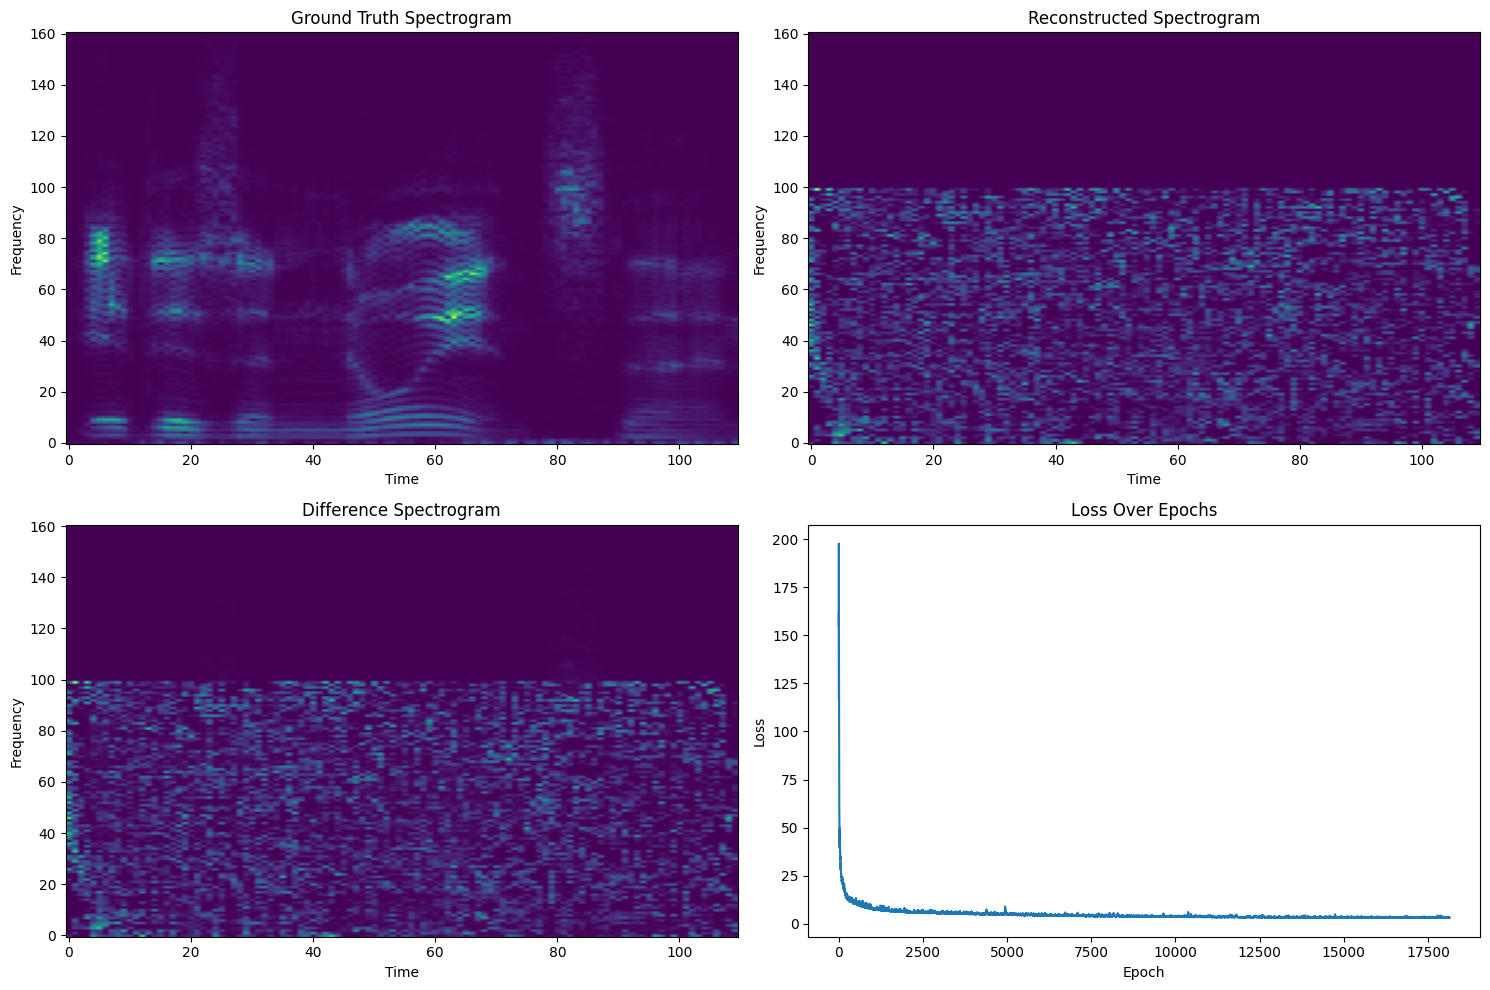

Iteration, Loss, Gradient Norm, Learning Rate: 18010, 3.2748, 0.7672, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18020, 3.1756, 0.5872, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18030, 3.1576, 0.4078, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18040, 3.2100, 0.7967, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18050, 3.1672, 0.6370, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18060, 3.2420, 0.5834, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18070, 3.2553, 0.7969, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18080, 3.4224, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18090, 3.3050, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18100, 3.2801, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18110, 3.1887, 0.8313, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18120, 3.4853, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 18130, 3.4375, 1.0000, 0.1000

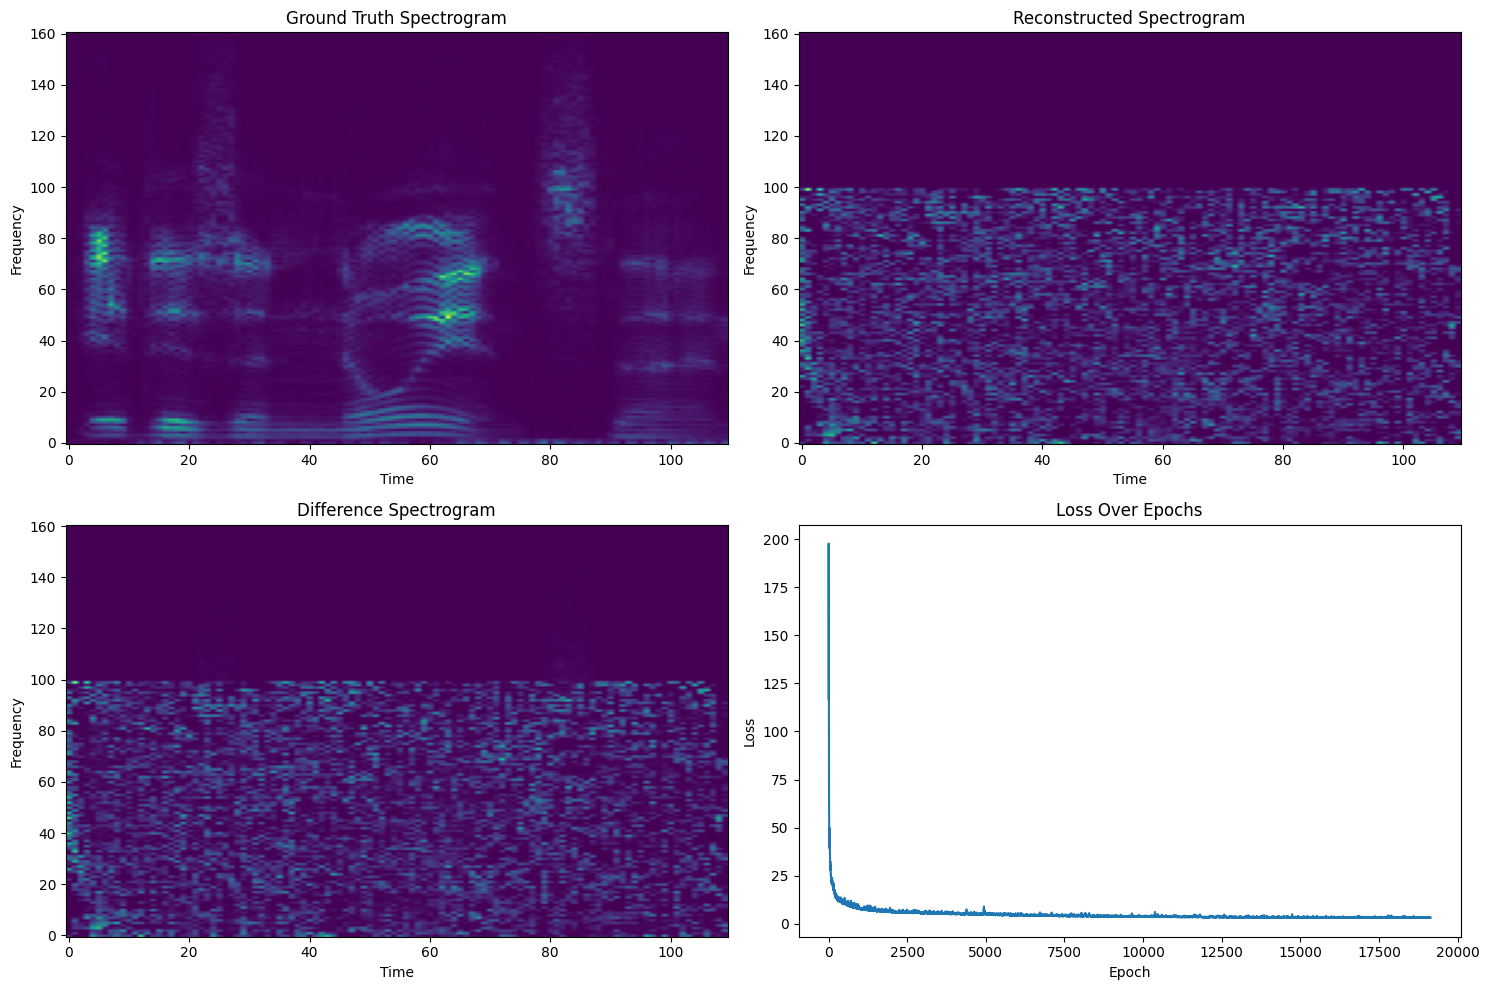

Iteration, Loss, Gradient Norm, Learning Rate: 19010, 3.1187, 0.6586, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19020, 3.2505, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19030, 3.1016, 0.5517, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19040, 3.1088, 0.6319, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19050, 3.2599, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19060, 3.2649, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19070, 3.3024, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19080, 3.3000, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19090, 3.3188, 0.9612, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19100, 3.1616, 0.5400, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19110, 3.2212, 0.8854, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19120, 3.1299, 0.9093, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 19130, 3.2941, 1.0000, 0.1000

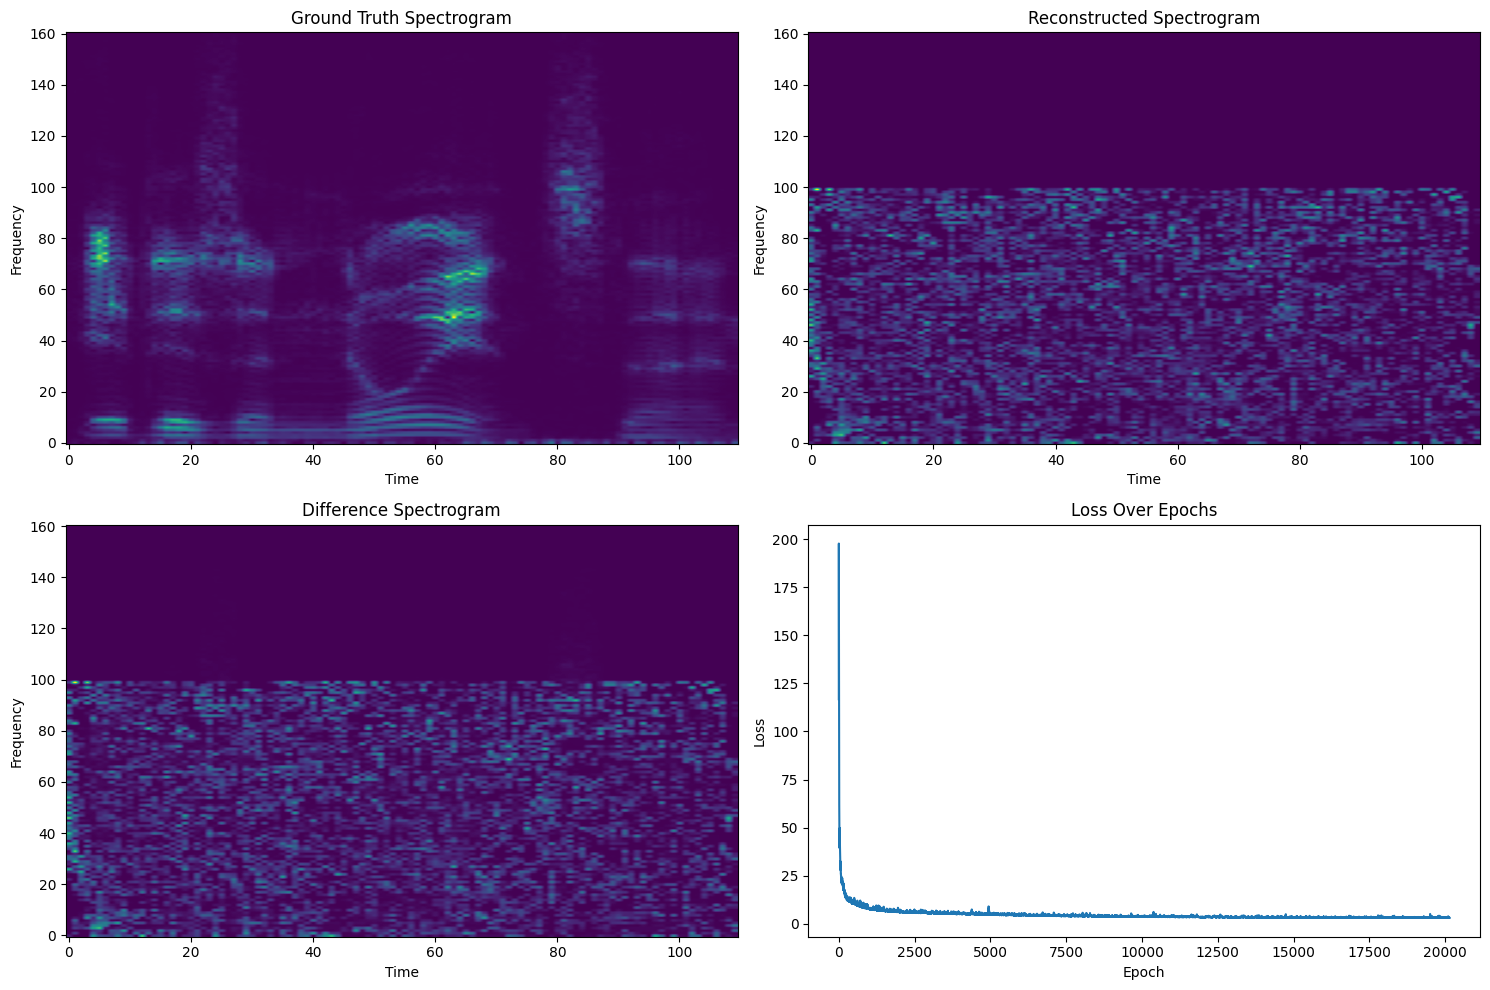

Iteration, Loss, Gradient Norm, Learning Rate: 20010, 3.1201, 0.7237, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20020, 3.2320, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20030, 3.0717, 0.6014, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20040, 3.1914, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20050, 3.3147, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20060, 3.1688, 0.8739, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20070, 3.0635, 0.4072, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20080, 3.0906, 0.6884, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20090, 3.1597, 0.6328, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20100, 3.2390, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20110, 3.2531, 0.9209, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20120, 3.3257, 1.0000, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate: 20130, 3.3892, 1.0000, 0.1000

In [51]:
while True:
    x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param_full, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)

    # L2 regularize
    # mloss += 1e-03 * torch.mean(x_param)

    optimizer.zero_grad()
    mloss.backward()
    grad = x_param.grad.data

    torch.nn.utils.clip_grad_norm_(x_param, 1.0)
    optimizer.step()
    scheduler.step(mloss)

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        # scheduler.step(mloss.item())

    if i % 1000 == 0:
        x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history,i)
        

    i+=1

In [50]:
# save the current x_param to file using torch.save
torch.save(x_param, 'x_param.pt')



In [ ]:
x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
# save figure with name that has date time hour min and epoch number
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d-%H-%M")
plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)
plt.savefig('figures/{}_{}.png'.format(now, i))
        

In [ ]:
while True:
    x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param_full, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_param.grad.data

    optimizer.step()
    scheduler.step(mloss.item())

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if i % 1000 == 0:
        x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)

    i+=1

In [ ]:
for g in optimizer.param_groups:
    g['lr']=0.1


In [ ]:
x_params_to_plot.transpose(2,3).squeeze().mean(dim=0)

In [ ]:
model_ds.

In [ ]:

inputs.transpose(2,3).squeeze().mean(dim=0)

## Plot sth

In [ ]:
def plot_tensor_distribution(x_param):
    import seaborn as sns
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
plot_tensor_distribution(x_param.detach())

In [ ]:
plot_tensor_distribution(inputs.detach())

In [ ]:
inputs.min()

In [ ]:
import numpy as np
np.log(1+7.9e-05)

In [ ]:
x_params.var()

In [ ]:
import seaborn as sns
def plot_tensor_distribution(x_param):
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
inputs_TF = inputs.transpose(-1,-2)

In [ ]:
inputs_TF.mean(dim=2)

In [ ]:
def plot_stem_tensor(tensor):
    """
    Plot a flattened version of a tensor in a stem plot to visualize how values change.
    
    Args:
        tensor (torch.Tensor): The tensor to be plotted.
    """
    plt.figure(figsize=(12, 4))
    flattened_tensor = tensor.flatten().cpu().numpy()
    plt.stem(range(len(flattened_tensor)), flattened_tensor, use_line_collection=True)
    plt.title('Stem Plot of Tensor Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [ ]:
plot_stem_tensor(inputs_TF.mean(dim=2))

In [ ]:
model_ds.fc[0]

In [ ]:
1000 * 20